In [159]:
import json
import numpy as np
import os
import pandas as pd
import urllib3
import urllib.request
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU
from keras.utils import np_utils
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

In [160]:
#coins = ['BTC', 'LTC', 'ETH', 'XRP']
coins = ['BTC']

In [161]:
# ratio of train to test split (originally at 0.8)
train_ratio = 0.9

In [179]:
from datetime import datetime, timedelta
from time import mktime

delta_days = 90

t = datetime.now()  +timedelta(days = 1)
end_tm = np.int(mktime(t.timetuple()))
tpast = t - timedelta(days=delta_days)
start_tm = np.int(mktime(tpast.timetuple()))
#start_tm = mktime((t - timedelta(days=delta_days)).tuple())
period_step = 300

In [180]:
df_list=[]

container = []

for coin in coins:
    url = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_'+coin+'&start={0}&end={1}&period={2}'.format(start_tm, end_tm, period_step)
    openUrl = urllib.request.urlopen(url)
    r = openUrl.read()
    openUrl.close()
    d = json.loads(r.decode())
    dfx = pd.DataFrame(d)
    dfx['coin'] = coin
    container.append(dfx)
    print(pd.DataFrame(d).shape)
    
container = pd.concat(container, axis = 0)
print('Returned length of {0} coins: {1}'.format(len(coins), container.shape))


# format
original_columns=[u'close', u'date', u'high', u'low', u'open']
new_columns = ['Close','Timestamp','High','Low','Open']
container = container.loc[:,original_columns]
container.columns = new_columns
container.to_csv('data/bitcoin2015to2017.csv',index=None)

# export out
h5path = 'data/4coins_17apr2021.h5'
container.to_hdf(h5path, key='df', mode='w')
#container.to_csv('data/4coins_17apr2021.csv',index=None)

(25633, 8)
Returned length of 1 coins: (25633, 9)


In [181]:
# validate returns
container.tail()

,Close,Timestamp,High,Low,Open
25628,61696.503252,1618653300,61723.253883,61548.056334,61582.850260
25629,61596.061880,1618653600,61733.719217,61596.061880,61697.000000
25630,61592.604497,1618653900,61607.535049,61389.535752,61596.061880
25631,61793.043940,1618654200,61835.161125,61599.545630,61600.602234
25632,61819.808954,1618654500,61883.100884,61774.620468,61778.938173


In [165]:

import numpy as np
import pandas as pd
 
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    '''
     
    def __init__(self, N, K, sliding_window = True):
        '''
        Predict K future sample using N previous samples
        '''
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, A):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #indexes
        if self.sliding_window:
            I = np.arange(M) + np.arange(A.shape[0] - M + 1).reshape(-1, 1)
        else:
            if A.shape[0]%M == 0:
                I = np.arange(M)+np.arange(0,A.shape[0],M).reshape(-1,1)
                
            else:
                I = np.arange(M)+np.arange(0,A.shape[0] -M,M).reshape(-1,1)
            
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix

#data file path
dfp = 'data/bitcoin2015to2017.csv'

#Columns of price data to use
columns = ['Close']
df = pd.read_csv(dfp)
time_stamps = df['Timestamp']
df = df.loc[:,columns]
original_df = pd.read_csv(dfp).loc[:,columns]

In [166]:

file_name='bitcoin2015to2017_close.h5'

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalization
for c in columns:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
    
#Features are input sample dimensions(channels)
A = np.array(df)[:,None,:]
original_A = np.array(original_df)[:,None,:]
time_stamps = np.array(time_stamps)[:,None,None]

#Make samples of temporal sequences of pricing data (channel)
NPS, NFS = 256, 16        #Number of past and future samples  -original at 16
ps = PastSampler(NPS, NFS, sliding_window=False)
B, Y = ps.transform(A)
input_times, output_times = ps.transform(time_stamps)
original_B, original_Y = ps.transform(original_A)

import h5py
with h5py.File(file_name, 'w') as f:
    f.create_dataset("inputs", data = B)
    f.create_dataset('outputs', data = Y)
    f.create_dataset("input_times", data = input_times)
    f.create_dataset('output_times', data = output_times)
    f.create_dataset("original_datas", data=np.array(original_df))
    f.create_dataset('original_inputs',data=original_B)
    f.create_dataset('original_outputs',data=original_Y)

In [167]:
# Make the program use only one GPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


with h5py.File(''.join(['bitcoin2015to2017_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value


output_file_name='bitcoin2015to2017_close_CNN_2_relu'

step_size = datas.shape[1]
batch_size= 10
nb_features = datas.shape[2]

epochs = 100

#split training validation
training_size = int(train_ratio* datas.shape[0])
training_datas = datas[:training_size,:]
training_labels = labels[:training_size,:]
validation_datas = datas[training_size:,:]
validation_labels = labels[training_size:,:]
#build model

# 2 layers
model = Sequential()


model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
model.add(Dropout(0.5))
model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))

'''
# 3 Layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=8))
# 4 layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=2))
'''

model.compile(loss='mse', optimizer='adam')
model.fit(training_datas, training_labels,verbose=1, batch_size=batch_size,validation_data=(validation_datas,validation_labels), epochs = epochs, callbacks=[CSVLogger(output_file_name+'.csv', append=True),ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=1,mode='min')])

C:\Anaconda\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Train on 84 samples, validate on 10 samples
Epoch 1/100
84/84 [==============================] - 1s 10ms/step - loss: 0.3816 - val_loss: 0.3947

Epoch 00001: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-01-0.39470.hdf5
Epoch 2/100
84/84 [==============================] - 0s 374us/step - loss: 0.1745 - val_loss: 0.0454

Epoch 00002: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-02-0.04542.hdf5
Epoch 3/100
84/84 [==============================] - 0s 357us/step - loss: 0.0998 - val_loss: 0.0022

Epoch 00003: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-03-0.00224.hdf5
Epoch 4/100
84/84 [==============================] - 0s 321us/step - loss: 0.0710 - val_loss: 0.0227

Epoch 00004: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-04-0.02265.hdf5
Epoch 5/100
84/84 [==============================] - 0s 309us/step - loss: 0.0587 - val_loss: 0.0279

Epoch 00005: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-05-0.02789.hdf5
Epoch 6

Epoch 44/100
84/84 [==============================] - 0s 393us/step - loss: 0.0091 - val_loss: 0.0016

Epoch 00044: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-44-0.00163.hdf5
Epoch 45/100
84/84 [==============================] - 0s 381us/step - loss: 0.0103 - val_loss: 0.0038

Epoch 00045: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-45-0.00385.hdf5
Epoch 46/100
84/84 [==============================] - 0s 377us/step - loss: 0.0111 - val_loss: 8.5838e-04

Epoch 00046: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-46-0.00086.hdf5
Epoch 47/100
84/84 [==============================] - 0s 333us/step - loss: 0.0102 - val_loss: 0.0011

Epoch 00047: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-47-0.00112.hdf5
Epoch 48/100
84/84 [==============================] - 0s 357us/step - loss: 0.0112 - val_loss: 0.0098

Epoch 00048: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-48-0.00984.hdf5
Epoch 49/100
84/84 [=====================

84/84 [==============================] - 0s 345us/step - loss: 0.0072 - val_loss: 0.0016

Epoch 00087: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-87-0.00160.hdf5
Epoch 88/100
84/84 [==============================] - 0s 381us/step - loss: 0.0091 - val_loss: 0.0014

Epoch 00088: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-88-0.00142.hdf5
Epoch 89/100
84/84 [==============================] - 0s 417us/step - loss: 0.0081 - val_loss: 0.0039

Epoch 00089: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-89-0.00387.hdf5
Epoch 90/100
84/84 [==============================] - 0s 381us/step - loss: 0.0102 - val_loss: 0.0012

Epoch 00090: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-90-0.00119.hdf5
Epoch 91/100
84/84 [==============================] - 0s 321us/step - loss: 0.0078 - val_loss: 0.0024

Epoch 00091: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-91-0.00243.hdf5
Epoch 92/100
84/84 [==============================] - 0s 2

In [182]:
from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import CSVLogger
import tensorflow as tf
from scipy.ndimage import imread
import numpy as np
import random
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
# import matplotlib

import matplotlib.pyplot as plt

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

with h5py.File(''.join(['bitcoin2015to2017_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value
    input_times = hf['input_times'].value
    output_times = hf['output_times'].value
    original_inputs = hf['original_inputs'].value
    original_outputs = hf['original_outputs'].value
    original_datas = hf['original_datas'].value
    

scaler=MinMaxScaler()
#split training validation
training_size = int(train_ratio* datas.shape[0])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,:]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,:]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]

ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
step_size = datas.shape[1]
batch_size= 10
nb_features = datas.shape[2]

model = Sequential()

# 2 layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
model.add(LeakyReLU())
model.add(Dropout(0.25))
model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))
model.load_weights('weights/bitcoin2015to2017_close_CNN_2_relu-100-0.00247.hdf5')
model.compile(loss='mse', optimizer='adam')

C:\Anaconda\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [175]:
predicted = model.predict(validation_datas)
predicted_inverted = []

for i in range(original_datas.shape[1]):
    scaler.fit(original_datas[:,i].reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
print (np.array(predicted_inverted).shape)
#get only the close data
ground_true = ground_true[:,:,0].reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times, unit='s')
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print (np.array(predicted_inverted).shape)
validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit='s')

(1, 10, 16)
(160,)


In [176]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true

prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted

#prediction_df = prediction_df.loc[(prediction_df["times"].dt.year == 2017 )&(prediction_df["times"].dt.month > 7 ),: ]
#ground_true_df = ground_true_df.loc[(ground_true_df["times"].dt.year == 2017 )&(ground_true_df["times"].dt.month > 7 ),:]

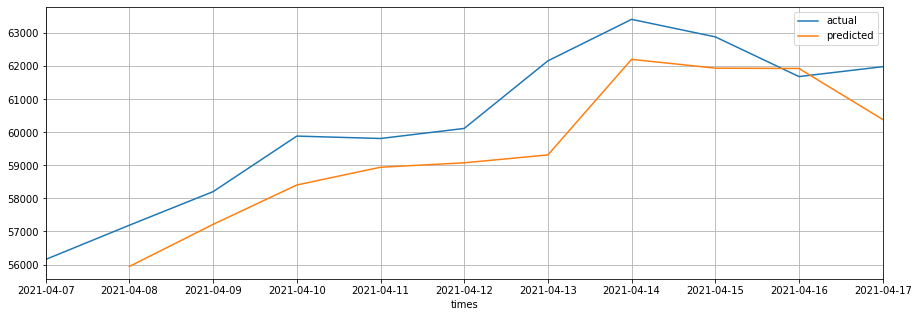

In [177]:
# aggregate to date
gt = ground_true_df.groupby(pd.to_datetime(ground_true_df.times).dt.date)[['value']].mean().reset_index()
gt.columns = ['times', 'actual']
pt = prediction_df.groupby(pd.to_datetime(prediction_df.times).dt.date)[['value']].mean().reset_index()
pt.columns = ['times', 'predicted']
allt = gt.merge(pt, on = 'times', how = 'outer')

allt.set_index('times').plot(figsize=(15,5), grid=True, label = True)

In [178]:
prediction_df.tail()

,times,value
155,2021-04-17 04:30:00,60830.195312
156,2021-04-17 04:35:00,60857.597656
157,2021-04-17 04:40:00,60696.039062
158,2021-04-17 04:45:00,60683.921875
159,2021-04-17 04:50:00,60646.898438


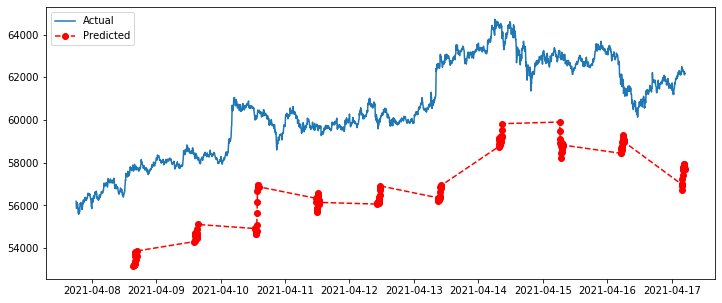

In [173]:
plt.figure(figsize=(12,5))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times,prediction_df.value,'ro--', label='Predicted')
plt.legend(loc='upper left')
plt.show()